## Temporal Context (Grid Image Generation)

In [1]:
from ksm import key_frame_selection
from data_loader import clip_path_loader
import torch
import torch.nn.functional as F
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import clip
from fastprogress import progress_bar
from sklearn import metrics
from scipy.ndimage import gaussian_filter1d
import cv2
import textwrap, re
from transformers import logging

warnings.filterwarnings(action='ignore')
logging.set_verbosity_error()

/home/sha/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def print_long_string(long_string, width=70):
    wrapped_string = textwrap.fill(long_string, width)
    print(wrapped_string)

def extract_numbers(file_name):
    numbers = re.findall(r'(\d+)', file_name)
    return tuple(map(int, numbers))

def transform2pil(image, transform=True):
    if transform:
        image = image * 255
        image = np.transpose(image, [1, 2, 0])
        image = (image).astype(np.uint8)
    image_pil = Image.fromarray(image)
    return image_pil

def show_pil_image(pil_image):
    plt.figure(figsize=(6, 6))
    plt.imshow(pil_image)
    plt.axis('off')  
    plt.show()

In [18]:
def extract_score(text):
    match = re.search(r'(\d+(\.\d+)?)', text)
    if match:
        return float(match.group(0))
    else:
        return 0.0

def generate_output(text):
    result = {
        "score": extract_score(text),
        "reason": text
    }
    return result

def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps  # Avoid division by zero
    normalized_arr = (arr - min_val) / denominator
    return normalized_arr

def show_score_graph(answers_idx, scores, auc, x='Frame', y='Anomaly Score'):
    length = len(scores)
    plt.clf()
    plt.plot([num for num in range(length)],[score for score in scores], label=f'AUC={auc:.2f}%') # plotting
    plt.bar(answers_idx, max(scores), width=1, color='r',alpha=0.5, label='Ground-truth') # check answer
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(fontsize=12)

---

1. Key frame selection

In [3]:
def key_frame_selection_four_idx(clip_length, clip_path, anomaly_text, model, preprocess, device):
    images = [preprocess(Image.open(img_path)).unsqueeze(0).to(device) for img_path in clip_path]
    images = torch.cat(images)
    texts = clip.tokenize([anomaly_text for _ in range(1)]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(images).float()
        text_features = model.encode_text(texts).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (text_features @ image_features.T).cpu().numpy() # (1, clip_length)

        # key frames selection
        max_idx = np.argmax(similarity)
        group_len = clip_length // 4
        divide_output = max_idx % group_len

        first_idx = divide_output
        second_idx = group_len+divide_output
        third_idx = group_len*2+divide_output
        fourth_idx = group_len*3+divide_output

    return first_idx, second_idx, third_idx, fourth_idx

2. Grid Image Generation

In [4]:
def split_images_with_unfold(image_paths, kernel_size=(80, 80), stride_size=None):
    all_patches = []
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (240, 240)).astype('float32')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
        image = (image / 255)
        image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()  # (H, W, C) -> (C, H, W) -> (1, C, H, W)
        
        if stride_size == None:
            stride_size = kernel_size

        org_patches = F.unfold(image, kernel_size=(kernel_size[0], kernel_size[1]), stride=(stride_size[0], stride_size[1]))
        patches = org_patches.permute(0, 2, 1).reshape(-1, 3, kernel_size[0], kernel_size[1])
        patches = F.interpolate(patches, size=(224, 224), mode='bilinear')
        all_patches.append(patches)
    
    grouped_patches = []
    num_patches = org_patches.shape[2]

    for i in range(num_patches):
        grouped_patches.append(torch.stack([patch_set[i] for patch_set in all_patches]))
    
    return grouped_patches

3. Grid Selection

In [5]:
def patch_selection(gpatches, text, model, device):
    texts = clip.tokenize([text for _ in range(1)]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(texts).float()
        max_arr = []

        for gpatch in gpatches:
            gpatch = gpatch.to(device)
            image_features = model.encode_image(gpatch).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (text_features @ image_features.T).cpu().numpy() # (1, clip_length)
            max_arr.append(np.max(similarity))

        # key frames selection
        max_arr = np.array(max_arr)
        max_idx = np.argmax(max_arr)

    return max_idx

In [6]:
def grid_image_generation(gpatches, idx):
    gpatch = gpatches[idx]
    grid_image = np.zeros((3, 224, 224), dtype=np.float32)
    grid_image[:, 0:112, 0:112] = F.interpolate(gpatch[0].unsqueeze(0), size=(112, 112), mode='bilinear').numpy()
    grid_image[:, 0:112, 112:224] = F.interpolate(gpatch[1].unsqueeze(0), size=(112, 112), mode='bilinear').numpy()
    grid_image[:, 112:224, 0:112] = F.interpolate(gpatch[2].unsqueeze(0), size=(112, 112), mode='bilinear').numpy()
    grid_image[:, 112:224, 112:224] = F.interpolate(gpatch[3].unsqueeze(0), size=(112, 112), mode='bilinear').numpy()
    return grid_image

In [7]:
def grid_generation(image_paths, keyword, clip_model, device):
    gpatches_img = split_images_with_unfold(image_paths, kernel_size=(240, 240)) # 1x1
    gpatches_lge = split_images_with_unfold(image_paths, kernel_size=(120, 120)) # 2x2
    gpatches_mid = split_images_with_unfold(image_paths, kernel_size=(80, 80)) # 3x3
    gpatches_sml = split_images_with_unfold(image_paths, kernel_size=(60, 60)) # 4x4

    gpatches = [gpatch for gpatch in gpatches_img]
    gpatches += [gpatch for gpatch in gpatches_lge]
    gpatches += [gpatch for gpatch in gpatches_mid]
    gpatches += [gpatch for gpatch in gpatches_sml]

    max_patch_idx = patch_selection(gpatches, keyword, clip_model, device)
    grid_image = grid_image_generation(gpatches, max_patch_idx)
    output_image = transform2pil(grid_image)
    return output_image

----

## Load Model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)

In [9]:
from lvlm_func import load_lvlm, lvlm_test, make_instruction

[2025-01-08 14:51:55,391] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [10]:
# Model Parameter
model_path = "LVLM/weights/chatunivi"  # or "Chat-UniVi/Chat-UniVi-13B"
tokenizer, lvlm_model, image_processor = load_lvlm(model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


In [11]:
def make_temporal_instruction(keyword):
    instruction = (
        f"- **Task**: Evaluate whether the given image includes **{keyword}** on a scale from 0 to 1."
        f"A score of 1 means **{keyword}** is clearly present in the image, while a score of 0 means **{keyword}** is not present at all. "
        f"For intermediate cases, assign a value between 0 and 1 based on the degree to which **{keyword}** is visible.\n"
        f"- **Context**: The given image represents a sequence (row 1 column 1 → row 1 column 2 → row 2 column 1 -> row 2 column 2) illustrating temporal progression.\n" 
        f"- **Consideration**: The key is whether **{keyword}** is present in the image, not its focus. Thus, if **{keyword}** is present, even if it is not the main focus, assign a higher score like 1.0.\n"    
        f"- **Response**: Provide the score as a float, rounded to one decimal place, including a brief reason for the score in **one short sentence**."
    )
    return instruction

---

### Compare (Anomaly Detection)

In [12]:
video_folder_path = '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049'
lpath = '/home/sha/datasets/shanghai/testframemask/07_0049.npy' 
clip_length = 16

video_folder_name = video_folder_path.split('/')[-1]
video = clip_path_loader(video_folder_path, clip_length)
keyword = video_folder_path.split('/')[-2]

grid_path = save_dir_path = f'grid_save/{keyword}/{video_folder_name}'
if not os.path.exists(save_dir_path):
    os.makedirs(save_dir_path)
print('grid_path:', grid_path)

print(keyword)
print(len(video))

grid_path: grid_save/fighting/07_0049
fighting
30


1. w/o Temporal Context

In [13]:
predicted1 = []
insturuction = make_instruction(1, keyword)

for i, cp in enumerate(progress_bar(video, total=len(video))):
    # key frame selection
    key_path = key_frame_selection(cp, keyword, clip_model, clip_preprocess, device)
    print(i, key_path)

    # Anomaly Detection
    ad_response = lvlm_test(tokenizer, lvlm_model, image_processor, insturuction, key_path, None) 
    score = generate_output(ad_response)['score']

    # save anomaly score
    for _ in range(clip_length):
        predicted1.append(score)

0 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/014.jpg
1 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/016.jpg
2 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/034.jpg
3 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/056.jpg
4 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/071.jpg
5 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/095.jpg
6 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/102.jpg
7 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/112.jpg
8 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/140.jpg
9 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/155.jpg
10 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/170.jpg
11 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/191.jpg
12 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/197.jpg
13 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/213.jpg
14 /home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/235.jpg
15 /home/sha/dataset

2. w/ Temporal Context

0 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/002.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/006.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/010.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/014.jpg']


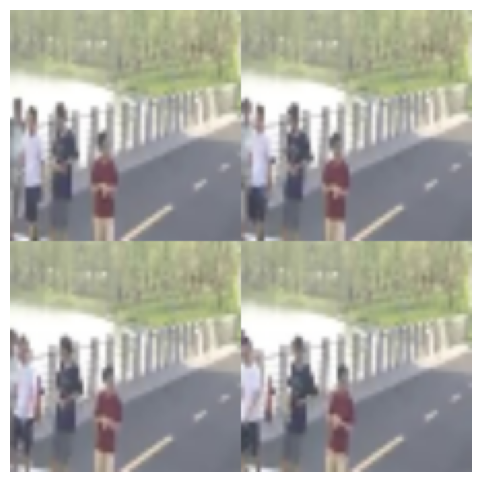

1 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/016.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/020.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/024.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/028.jpg']


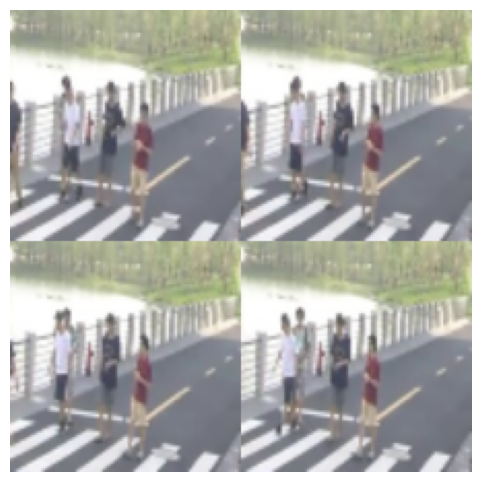

2 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/034.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/038.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/042.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/046.jpg']


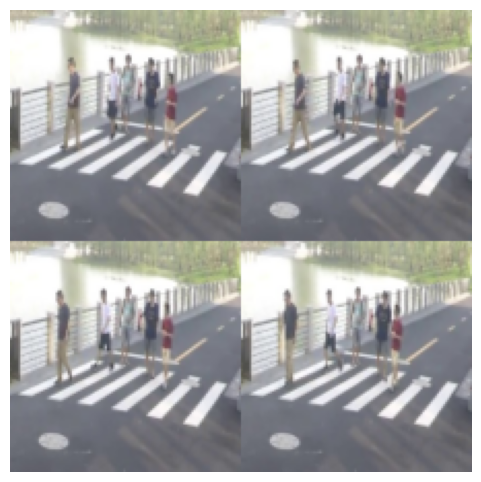

3 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/048.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/052.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/056.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/060.jpg']


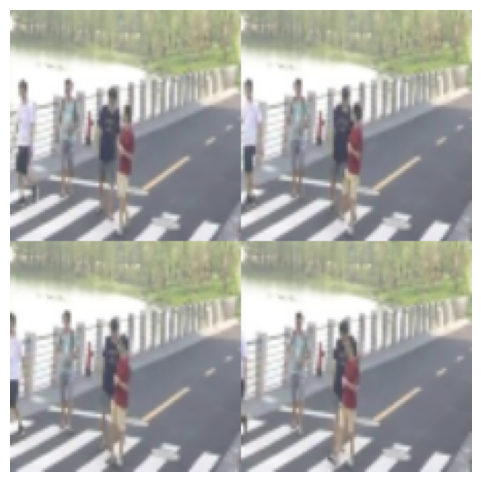

4 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/067.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/071.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/075.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/079.jpg']


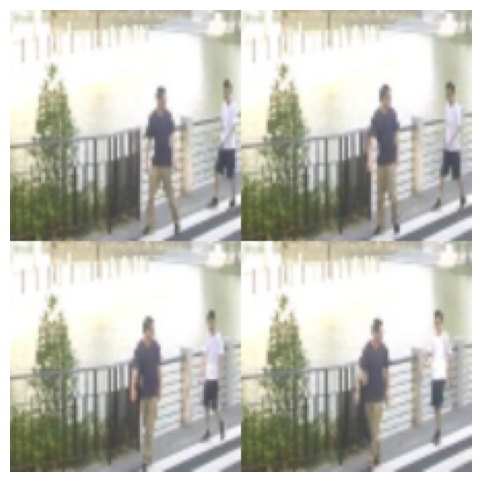

5 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/083.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/087.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/091.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/095.jpg']


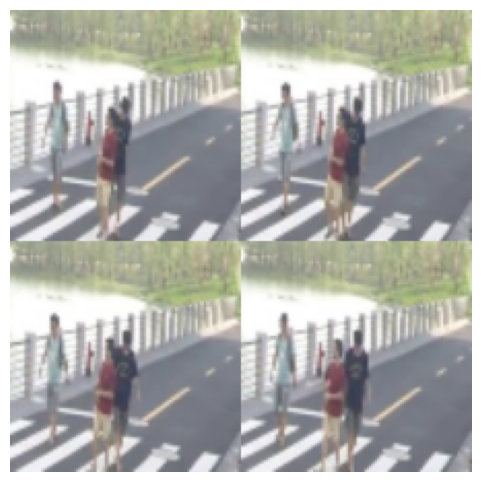

6 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/098.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/102.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/106.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/110.jpg']


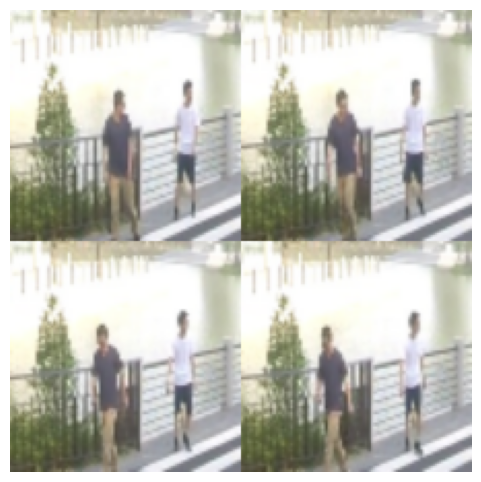

7 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/112.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/116.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/120.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/124.jpg']


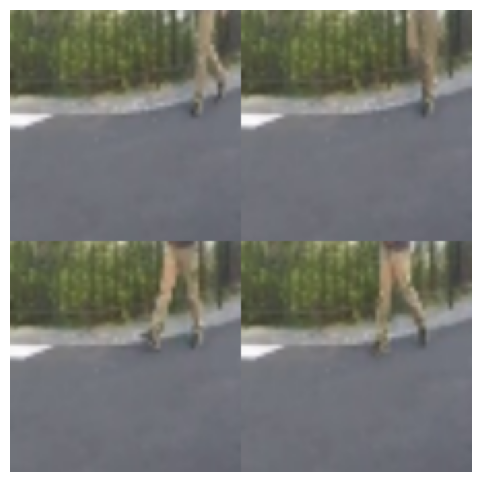

8 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/128.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/132.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/136.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/140.jpg']


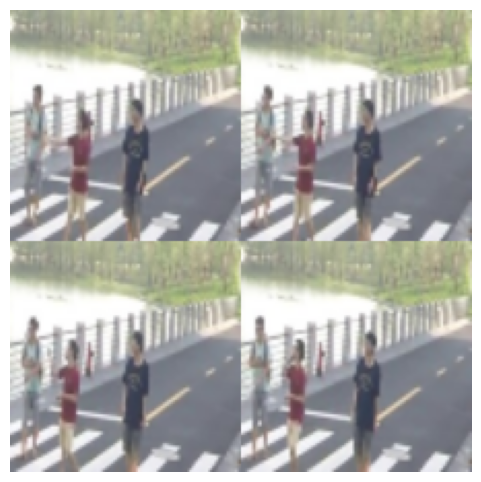

9 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/147.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/151.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/155.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/159.jpg']


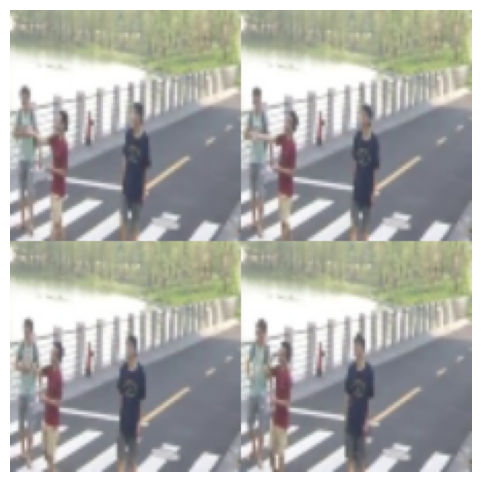

10 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/162.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/166.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/170.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/174.jpg']


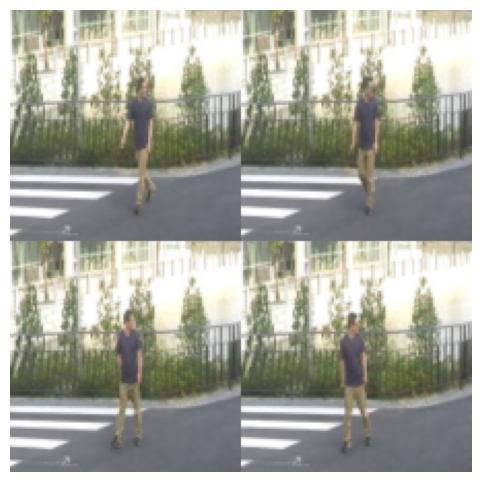

11 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/179.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/183.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/187.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/191.jpg']


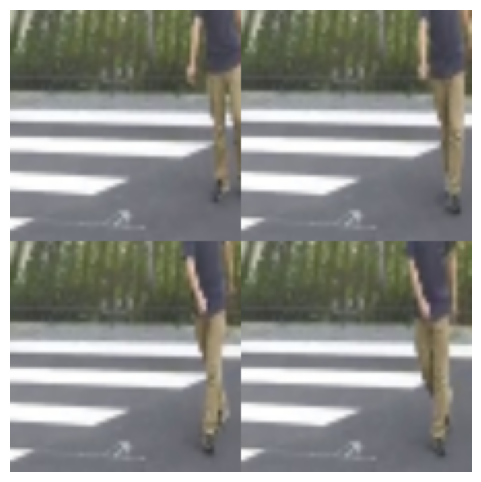

12 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/193.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/197.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/201.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/205.jpg']


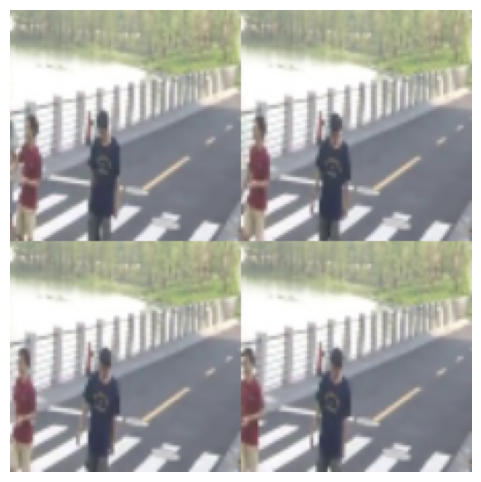

13 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/209.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/213.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/217.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/221.jpg']


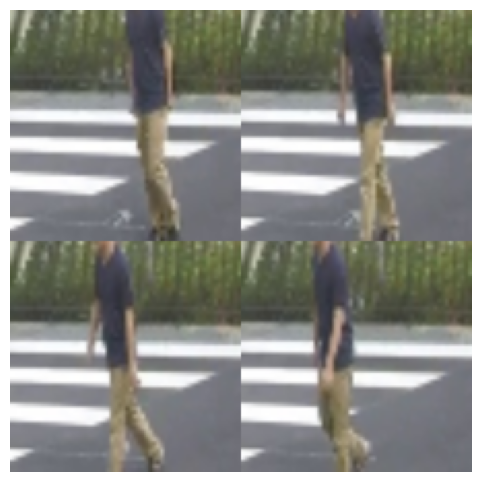

14 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/227.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/231.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/235.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/239.jpg']


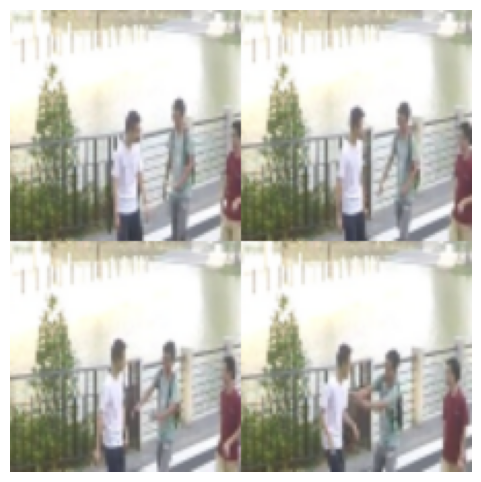

15 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/242.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/246.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/250.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/254.jpg']


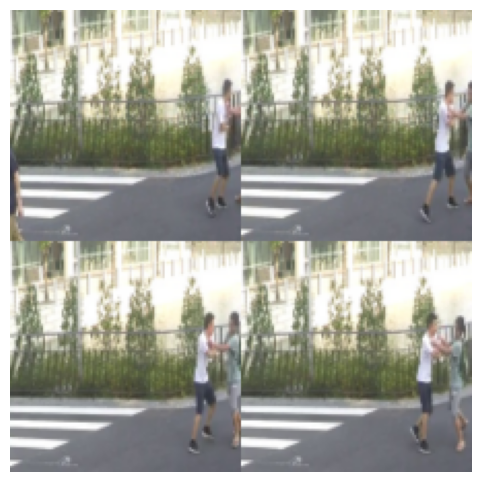

16 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/257.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/261.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/265.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/269.jpg']


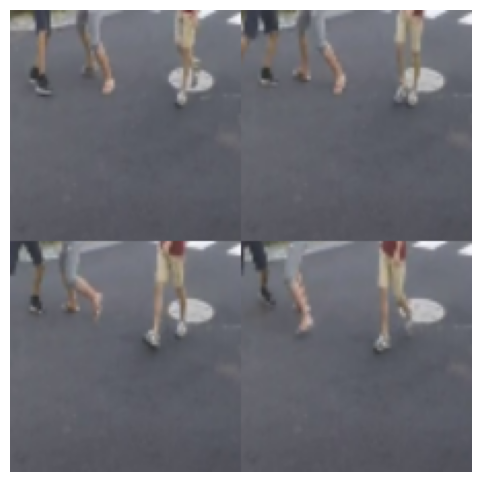

17 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/273.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/277.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/281.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/285.jpg']


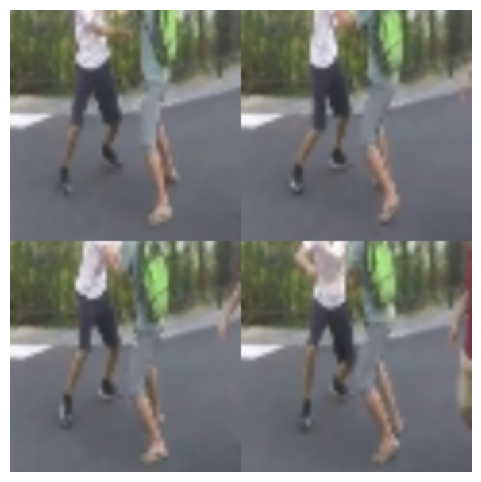

18 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/289.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/293.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/297.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/301.jpg']


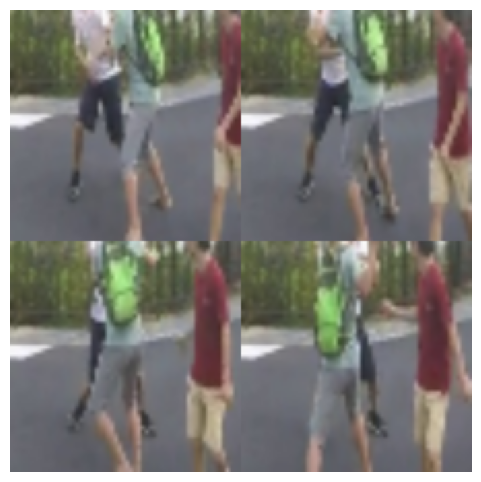

19 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/306.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/310.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/314.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/318.jpg']


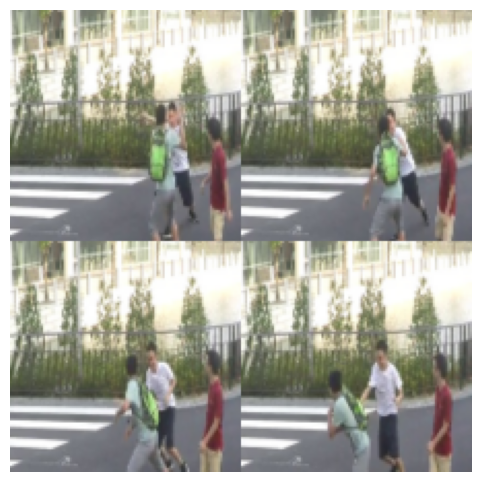

20 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/320.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/324.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/328.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/332.jpg']


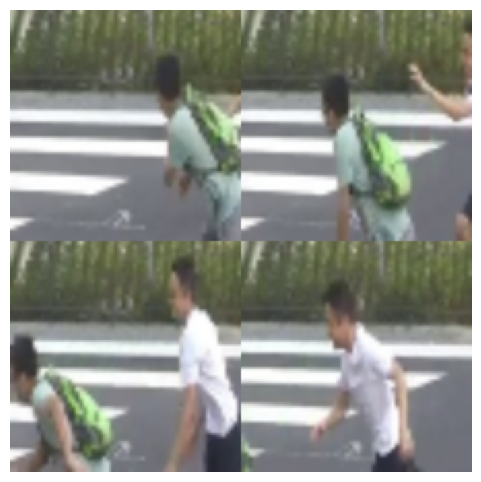

21 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/336.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/340.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/344.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/348.jpg']


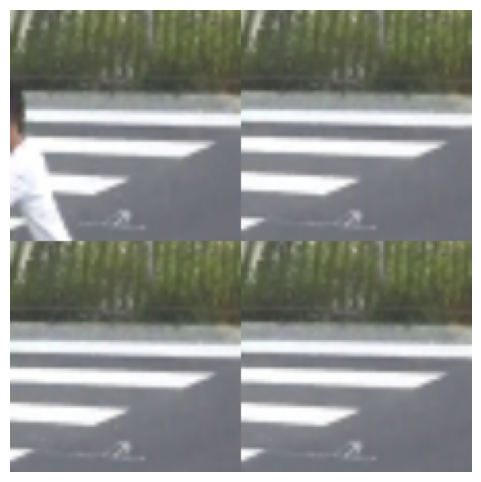

22 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/352.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/356.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/360.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/364.jpg']


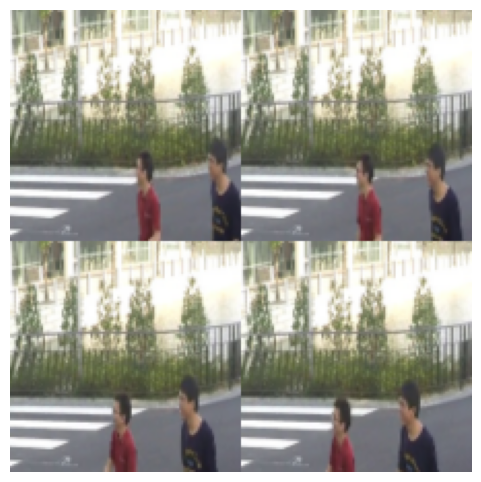

23 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/371.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/375.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/379.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/383.jpg']


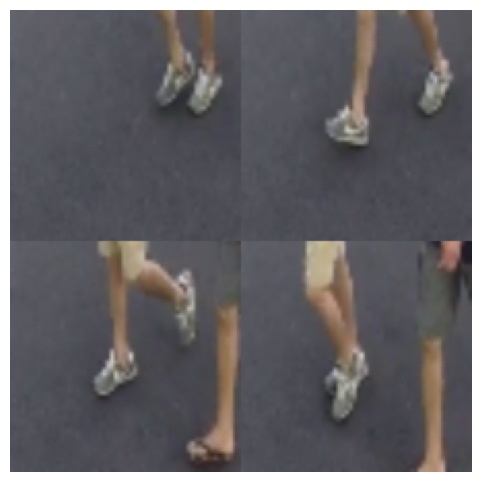

24 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/386.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/390.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/394.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/398.jpg']


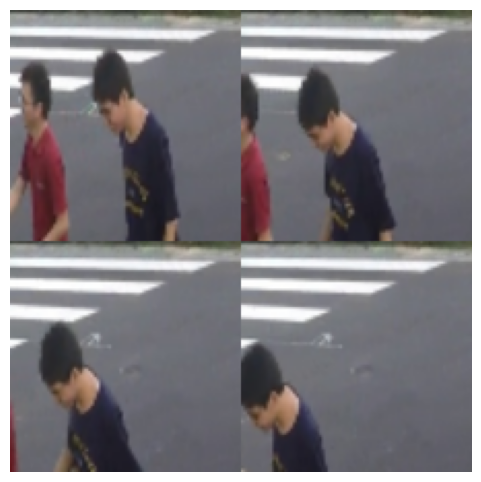

25 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/402.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/406.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/410.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/414.jpg']


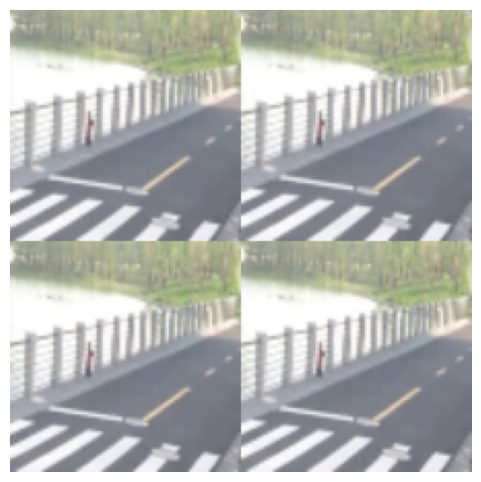

26 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/418.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/422.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/426.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/430.jpg']


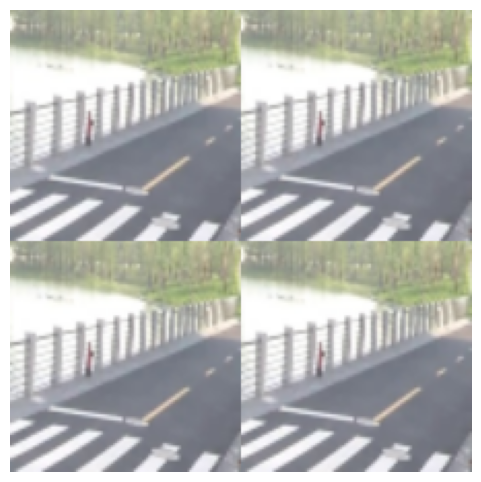

27 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/434.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/438.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/442.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/446.jpg']


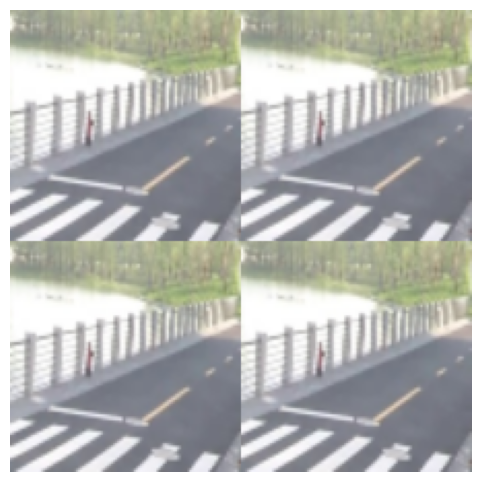

28 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/450.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/454.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/458.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/462.jpg']


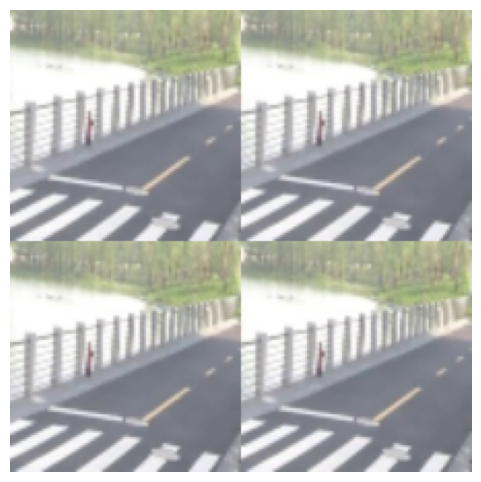

29 ['/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/467.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/471.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/475.jpg', '/home/sha/datasets/cvad_data/c-shtech/fighting/07_0049/479.jpg']


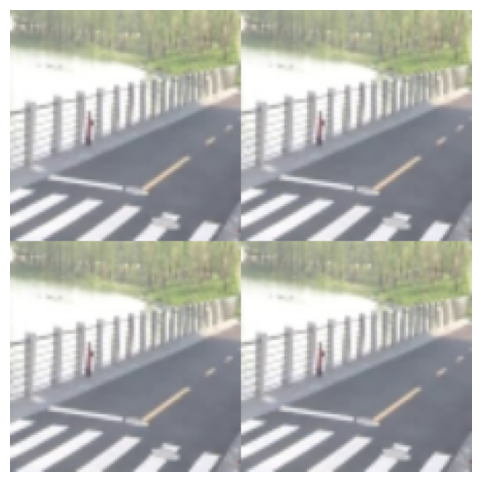

In [19]:
predicted2 = []
insturuction2 = make_temporal_instruction(keyword)

for clip_idx, clip_path in enumerate(progress_bar(video, total=len(video))):
    # key frames selection
    indice = key_frame_selection_four_idx(clip_length, clip_path, keyword, clip_model, clip_preprocess, device)
    image_paths = [clip_path[idx] for idx in indice]
    print(clip_idx, image_paths)

    # temporal context generation
    grid_image = grid_generation(image_paths, keyword, clip_model, device)
    show_pil_image(grid_image)

    # Anomaly Detection
    generated_text = lvlm_test(tokenizer, lvlm_model, image_processor, insturuction2, None, grid_image)
    score = generate_output(generated_text)['score']

    # save anomaly score
    for _ in range(clip_length):
        predicted2.append(score)

In [15]:
gt = np.load(lpath)[:len(predicted2)]

sigma: 2 auc: 0.7620657894736842


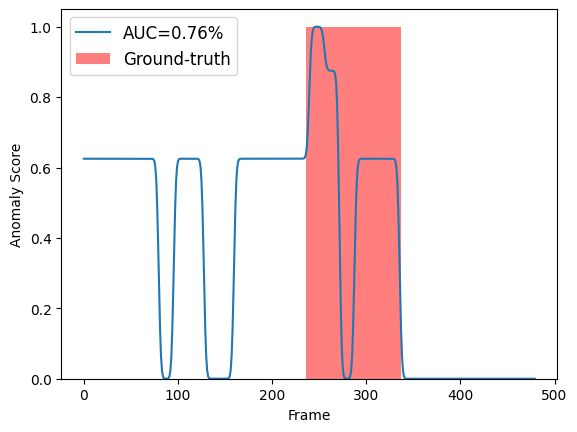

In [16]:
best_auc1 = 0 
for sigma in range(1, 100):
    g_predicted1 = gaussian_filter1d(predicted1, sigma=sigma)
    mm_predicted1 = min_max_normalize(g_predicted1)

    # get auc
    fpr, tpr, _ = metrics.roc_curve(gt, mm_predicted1, pos_label=1)
    auc1 = metrics.auc(fpr, tpr)

    if auc1 > best_auc1:
        best_sigma1 = sigma
        best_auc1 = auc1
        best_predicted1 = mm_predicted1  

# show anomaly scores and AUC
anomalies_idx = [i for i,l in enumerate(gt) if l==1] 
print('sigma:',best_sigma1, 'auc:',best_auc1)
show_score_graph(anomalies_idx, best_predicted1, best_auc1)

sigma: 32 auc: 0.9896315789473684


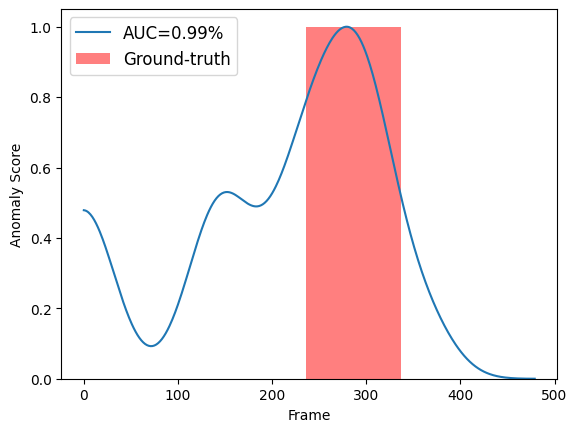

In [17]:
best_auc2 = 0 
for sigma in range(1, 100):
    g_predicted2 = gaussian_filter1d(predicted2, sigma=sigma)
    mm_predicted2 = min_max_normalize(g_predicted2)

    # get auc
    fpr, tpr, _ = metrics.roc_curve(gt, mm_predicted2, pos_label=1)
    auc2 = metrics.auc(fpr, tpr)
    
    # show
    if auc2 > best_auc2:
        best_sigma2 = sigma
        best_auc2 = auc2
        best_predicted2 = mm_predicted2  

# show anomaly scores and AUC
anomalies_idx = [i for i,l in enumerate(gt) if l==1] 
print('sigma:',best_sigma2, 'auc:',best_auc2)
show_score_graph(anomalies_idx, best_predicted2, best_auc2)